## Описание задачи
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

## Описание колонок 
* `experimentVariant` – вариант эксперимента
* `version` – версия приложения
* `purchase` – факт покупки

## Задача
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

### 💡 Ответ: как найти причины поломки?

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

* Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
* Посчитайте pvalue для каждой версии МП
* Найдите версии, где pvalue < 0.05
* Исключите версию с pvalue < 0.05 из основного датафрейма
* Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
* Вы нашли поломку

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, mannwhitneyu

from scipy import stats
from tqdm.auto import tqdm

plt.style.use('fivethirtyeight')

In [40]:
data = pd.read_csv('hw_aa.csv', sep = ';')
data = data.drop('Unnamed: 0', axis = 1)
data.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [41]:
data.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [42]:
data_0 = data.query('experimentVariant == 0')
data_1 = data.query('experimentVariant == 1')
group_1 = data_0['purchase']
group_2 = data_1['purchase']


In [43]:
stats.ttest_ind(group_1, group_2)[1]

7.701996608732486e-162

### Делаем тест

In [44]:
simulations = 1000
n = 1000
p_value = []

for i in tqdm(range(simulations)):
    g_1 = group_1.sample(n, replace=False)
    g_2 = group_2.sample(n, replace=False)
    p_value.append(stats.ttest_ind(g_1, g_2, equal_var = False)[1])

  0%|          | 0/1000 [00:00<?, ?it/s]

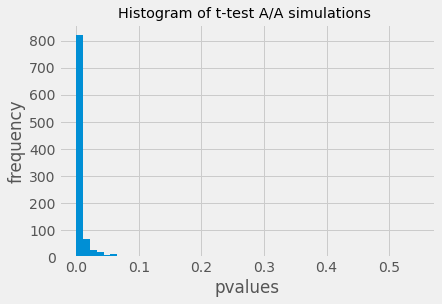

In [45]:
plt.hist(p_value, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()



In [46]:
FPR = sum(np.array(p_value) < 0.05) / simulations
print(FPR)

0.939


In [47]:
data.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [48]:
data_grouped = data.groupby('experimentVariant').agg({'uid': 'count', 'purchase': 'sum'})
data_grouped

,uid,purchase
experimentVariant,,
0,63102,1511
1,63916,3403


In [49]:
data_grouped['conversion'] = data_grouped.purchase/data_grouped.uid * 100
data_grouped

,uid,purchase,conversion
experimentVariant,,,
0,63102,1511,2.394536
1,63916,3403,5.324175


In [50]:
df_grouped_ver = data.groupby(['experimentVariant', 'version']).agg({'uid': 'count', 'purchase': 'sum'})
df_grouped_ver

uid  purchase
experimentVariant version                  
0                 v2.8.0    41283        41
                  v2.9.0    11921       890
                  v3.7.4.0   4204       252
                  v3.8.0.0   5694       328
1                 v2.8.0    41552      1895
                  v2.9.0    12033       858
                  v3.7.4.0   4221       266
                  v3.8.0.0   6110       384

In [51]:
df_grouped_ver['conv'] = df_grouped_ver.purchase/df_grouped_ver.uid * 100
df_grouped_ver

uid  purchase      conv
experimentVariant version                            
0                 v2.8.0    41283        41  0.099314
                  v2.9.0    11921       890  7.465817
                  v3.7.4.0   4204       252  5.994291
                  v3.8.0.0   5694       328  5.760450
1                 v2.8.0    41552      1895  4.560551
                  v2.9.0    12033       858  7.130391
                  v3.7.4.0   4221       266  6.301824
                  v3.8.0.0   6110       384  6.284779

Можно заметить, что конверсия для версии `v2.8.0` заметно различается в двух вариантах эксперимента (в нулевую группу попадает значительно меньше покупателей, чем в первую). В результате нарушается репрезентативность тестовых групп. Возможно, причина поломки именно в этой версии приложения.

## Попробуем запустить A/A-тест для каждой версии приложения по отдельности

In [52]:
def ver(data_0, data_1, vers):

    group_1 = data_0[data_0.version == vers].purchase
    group_2 = data_1[data_1.version == vers].purchase

    simulations = 1000
    n = 1000
    p_value = []

    for i in tqdm(range(simulations)):
        g_1 = group_1.sample(n, replace=False)
        g_2 = group_2.sample(n, replace=False)
        p_value.append(stats.ttest_ind(g_1, g_2, equal_var = False)[1])

    plt.hist(p_value, bins = 50)
    plt.style.use('fivethirtyeight')
    plt.xlabel('pvalue')
    plt.ylabel('frequency')
    plt.title(f"Histogram of t-test A/A simulations, Version = {vers}")
    plt.show()

    FPR = sum(np.array(p_value) < 0.05) / simulations
    print('FPR', FPR)

  0%|          | 0/1000 [00:00<?, ?it/s]

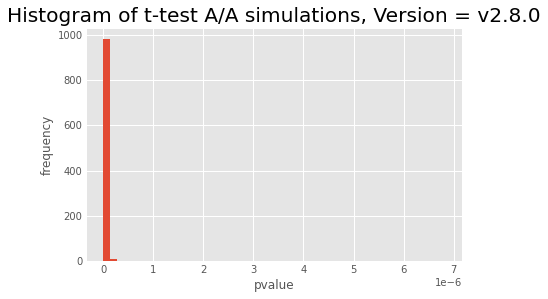

FPR 1.0


In [53]:
ver(data_0, data_1,'v2.8.0')

  0%|          | 0/1000 [00:00<?, ?it/s]

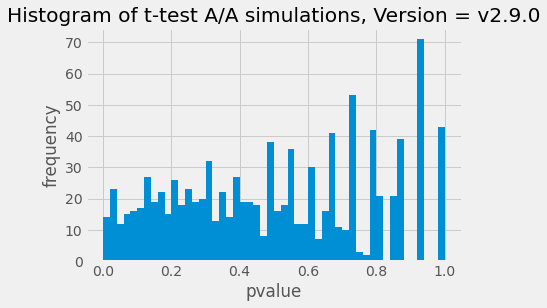

FPR 0.04


In [54]:
ver(data_0, data_1,'v2.9.0')

  0%|          | 0/1000 [00:00<?, ?it/s]

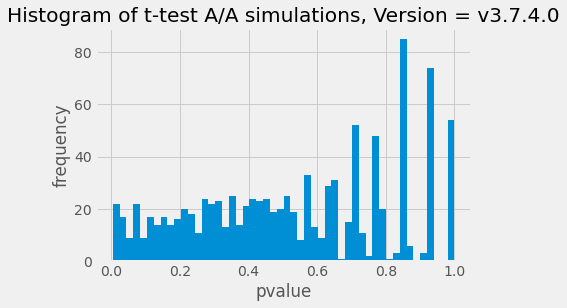

FPR 0.041


In [55]:
ver(data_0, data_1,'v3.7.4.0')

  0%|          | 0/1000 [00:00<?, ?it/s]

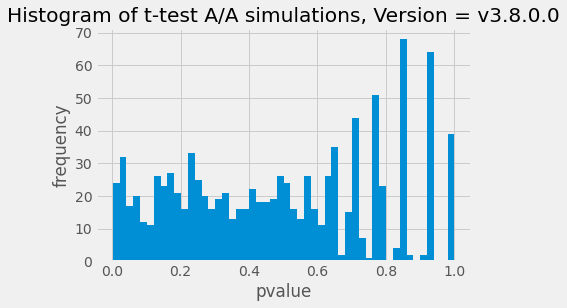

FPR 0.062


In [56]:
ver(data_0, data_1,'v3.8.0.0')

### Результаты A/A-теста для каждой версии приложения
Теперь хорошо видно, что для версии `v2.8.0` t-тест выдает значимые различия на каждой итерации теста (`FPR составляет 1.0`), тогда как с остальными версиями все нормально - доля ложноположительных оценок низкая. Значит, причина поломки действительно кроется в версии `v2.8.0`. Возможно, что для данной версии сломан рандомизатор, распределяющий пользователей по группам эксперимента.

## Теперь запустим A/A-тест, предварительно исключив из выборки проблемную версию

  0%|          | 0/1000 [00:00<?, ?it/s]

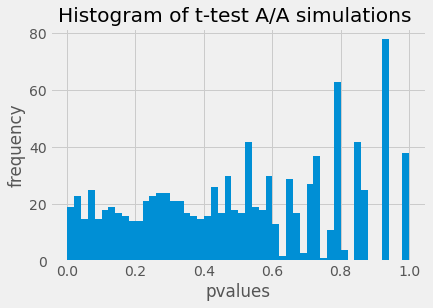

FPR 0.047


In [57]:
group_1 = data_0.query('version != "v2.8.0"').purchase
group_2 = data_1.query('version != "v2.8.0"').purchase

simulations = 1000
n = 1000
p_value = []

for i in tqdm(range(simulations)):
    g_1 = group_1.sample(n, replace=False)
    g_2 = group_2.sample(n, replace=False)
    p_value.append(stats.ttest_ind(g_1, g_2, equal_var = False)[1])

plt.hist(p_value, bins = 50)
plt.style.use('fivethirtyeight')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of t-test A/A simulations ")
plt.show()

FPR = sum(np.array(p_value) < 0.05) / simulations
print('FPR', FPR)

Без проблемной версии `все работает нормально`, и мы находимся в пределах допустимого значения `FPR`. Теперь мы знаем, что именно у нас сломалось. Ура!

P.S. Также можно заметить, что в нашем примере при повторных запусках А/А-тестов в некоторых случаях FPR будет немного превышать пороговое значение (`0.05`). Это связано с относительно небольшим числом наблюдений (`1000`) в выборках на каждой итерации теста